In [75]:
import requests
import functools
import pandas as pd
import numpy as np

import osr

import matplotlib.pyplot as plt

src_crs = osr.SpatialReference()
src_crs.ImportFromEPSG(25831)
dst_crs = osr.SpatialReference()
dst_crs.ImportFromEPSG(3857)
src2dst = osr.CoordinateTransformation(src_crs, dst_crs)

In [76]:
# the url for getting metadata (locations, measurement types)
ddl_url = 'https://waterwebservices.rijkswaterstaat.nl/METADATASERVICES_DBO/OphalenCatalogus/'
ddl_data_url = 'https://waterwebservices.rijkswaterstaat.nl/ONLINEWAARNEMINGENSERVICES_DBO/OphalenWaarnemingen'


In [77]:
request = {
    "CatalogusFilter": {
        "Eenheden": True,
        "Grootheden": True,
        "Hoedanigheden": True
    }
}
resp = requests.post(ddl_url, json=request)
result = resp.json()

In [81]:
result['AquoMetadataLijst']

[{'AquoMetadata_MessageID': 1,
  'Eenheid': {'Code': 'mg/kg', 'Omschrijving': 'milligram per kilogram'},
  'Grootheid': {'Code': 'MASSFTE', 'Omschrijving': 'Massafractie'},
  'Hoedanigheid': {'Code': 'Ndg',
   'Omschrijving': 'uitgedrukt in Stikstof / drooggewicht'},
  'Parameter_Wat_Omschrijving': 'Massafractie stikstof Kjeldahl in Zwevende stof uitgedrukt in Stikstof / drooggewicht in mg/kg'},
 {'AquoMetadata_MessageID': 2,
  'Eenheid': {'Code': 'ng/l', 'Omschrijving': 'nanogram per liter'},
  'Grootheid': {'Code': 'CONCTTE', 'Omschrijving': '(massa)Concentratie'},
  'Hoedanigheid': {'Code': 'Sn', 'Omschrijving': 'uitgedrukt in Tin'},
  'Parameter_Wat_Omschrijving': '(massa)Concentratie dibutyltin (kation) in Oppervlaktewater uitgedrukt in Tin in ng/l'},
 {'AquoMetadata_MessageID': 3,
  'Eenheid': {'Code': 'ug/l', 'Omschrijving': 'microgram per liter'},
  'Grootheid': {'Code': 'CONCTTE', 'Omschrijving': '(massa)Concentratie'},
  'Hoedanigheid': {'Code': 'Sn', 'Omschrijving': 'uitgedr

In [4]:
df = pd.DataFrame.from_dict(result['LocatieLijst'])
df = df.set_index('Code')
# note that there are two stations for IJmuiden. 
# The station was moved from the sluices to outside of the harbor in 1981.
ids = ['DELFZL', 'DENHDR', 'HARLGN', 'HOEKVHLD', 'IJMDBTHVN', 'IJMDNDSS', 'VLISSGN']

# make a copy so we can add things
stations_df = df.loc[ids].copy()
# this drops IJMDNSS
stations_df[['Naam', 'X', 'Y']]
stations_df

,Coordinatenstelsel,Locatie_MessageID,Naam,X,Y
Code,,,,,
DELFZL,25831,84020,Delfzijl,761899.770960,5.915790e+06
DENHDR,25831,84011,Den Helder,617198.393684,5.869731e+06
HARLGN,25831,84096,Harlingen,661021.585505,5.894519e+06
HOEKVHLD,25831,72345,Hoek van Holland,576917.669784,5.759136e+06
IJMDBTHVN,25831,84132,IJmuiden buitenhaven,605633.035699,5.813598e+06
IJMDNDSS,25831,84560,IJmuiden Noordersluis,609033.673551,5.814221e+06
VLISSGN,25831,84387,Vlissingen,541425.983215,5.699182e+06


In [5]:
locaties_df = pd.DataFrame.from_dict(result['LocatieLijst'])
metadata_locaties_df = pd.DataFrame.from_dict(result['AquoMetadataLocatieLijst'])
metadata_df = pd.DataFrame.from_dict(result['AquoMetadataLijst'])


In [6]:
dfs = [locaties_df, metadata_locaties_df, metadata_df]
for df in dfs:
    df.columns = [x.lower() for x in df.columns]
merged_df = functools.reduce(
    lambda left, right: pd.merge(left, right), 
    dfs
)


In [7]:
xyz_web_list = src2dst.TransformPoints(np.c_[merged_df.x, merged_df.y])
xyz_web = np.array(xyz_web_list)
merged_df['x_web'] = xyz_web[:, 0]
merged_df['y_web'] = xyz_web[:, 1]

In [8]:
idx = merged_df['grootheid'].apply(lambda x: x['Omschrijving'] == 'Saliniteit')
salinity_stations = merged_df[idx]
idx = merged_df['grootheid'].apply(lambda x: x['Omschrijving'] == 'Debiet')
discharge_stations = merged_df[idx]
idx = merged_df['grootheid'].apply(lambda x: x['Omschrijving'] == 'Waterhoogte')
sea_surface_level_stations = merged_df[idx]


(5628778.4661693703, 6013888.4171688901)

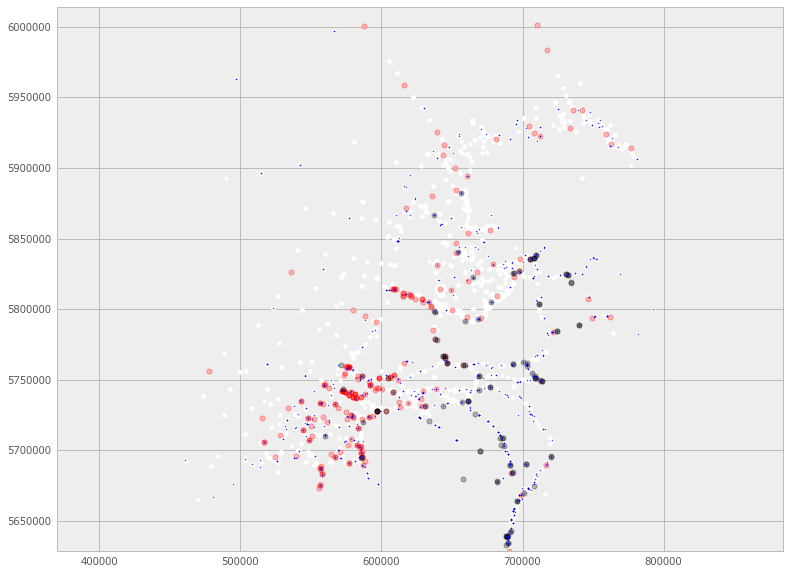

In [9]:
fig, ax = plt.subplots(figsize=(13, 10))
ax.plot(merged_df.x, merged_df.y, 'w.')
ax.plot(salinity_stations.x, salinity_stations.y, 'r.', alpha=0.3, markersize=10)
ax.plot(discharge_stations.x, discharge_stations.y, 'ko', alpha=0.3, markersize=5)
ax.plot(sea_surface_level_stations.x, sea_surface_level_stations.y, 'b.', alpha=0.8, markersize=1)

ax.axis('equal')
ax.set_xlim(salinity_stations.x.min(), salinity_stations.x.max())
ax.set_ylim(salinity_stations.y.min(), salinity_stations.y.max() - 100000)


In [10]:
# list of all quantities
set(merged_df['grootheid'].apply(lambda x: x['Omschrijving']))

{'(massa)Concentratie',
 'Aantal per volume',
 'Debiet',
 'Deiningsenergie in het spectrale domein',
 'Doorzicht',
 'Geleidendheid',
 'Gem. golfperiode langste 1/3 deel v.d. golven (tijdsdomein)',
 'Gem. hoogte van hoogste 1/3 deel v.d. golven (tijdsdomein)',
 'Gem. richting deining tov ware noorden in spectrale domein',
 'Gemiddelde golfrichting in het spectrale domein',
 'Geurverdunningsfactor',
 'Golffrequentie bij maximum v.h. variantiedichtheidspectrum',
 'Golfperiode bepaald uit de spectrale momenten m0 en m2',
 'Hardheid',
 'Korrelgroottefractie',
 'Luchtdruk',
 'Massafractie',
 'Meteorologisch zicht',
 'Saliniteit',
 'Significante deiningshoogte in het spectrale domein',
 'Significante golfhoogte in het spectrale domein',
 'Stroomrichting',
 'Stroomsnelheid',
 'Temperatuur',
 'Verzadigingsgraad',
 'Waarde is niet van toepassing',
 'Waterhoogte',
 'Waterhoogte berekend',
 'Windrichting',
 'Windsnelheid',
 'Zuurgraad',
 'gem. golfperiode hoogste 1/3 deel golven'}

In [12]:
import bokeh.plotting 
import bokeh.io
import bokeh.tile_providers


bokeh.io.output_notebook()

from bokeh.models import HoverTool

sources = []
for df in [salinity_stations, discharge_stations, sea_surface_level_stations]:
    source = bokeh.plotting.ColumnDataSource(data=dict(
        x=df['x_web'],
        y=df['y_web'],
        desc=df.code,
        quantity=df.grootheid.apply(lambda x: x['Omschrijving'])
    ))
    sources.append(source)

hover = HoverTool(tooltips=[
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("desc", "@desc: @quantity"),
])

p = bokeh.plotting.figure(
    plot_width=800, plot_height=900,
    # match_aspect=True,
    title="Mouse over the dots"
)
p.add_tile(bokeh.tile_providers.CARTODBPOSITRON_RETINA)
p.add_tools(hover)
colors = ['red', 'blue', 'black']
for source, color in zip(sources, colors):
    p.circle('x', 'y', size=5, source=source, line_color=color, alpha=0.3)

p.x_range.start = salinity_stations.x_web.min()
p.x_range.end = salinity_stations.x_web.max()
p.y_range.start = salinity_stations.y_web.min()
p.y_range.end = salinity_stations.y_web.max() - 100000

bokeh.io.show(p)


Loading BokehJS ...

In [14]:
merged_df[merged_df.code == 'BRIENOD']
merged_df[merged_df.code == 'HOEKVHLD']

,code,coordinatenstelsel,locatie_messageid,naam,x,y,aquometadata_messageid,eenheid,grootheid,hoedanigheid,parameter_wat_omschrijving,x_web,y_web
1679,HOEKVHLD,25831,72345,Hoek van Holland,576917.669784,5.759136e+06,89,"{'Omschrijving': 'decimeter', 'Code': 'dm'}","{'Omschrijving': 'Doorzicht', 'Code': 'ZICHT'}","{'Omschrijving': 'Niet van toepassing', 'Code'...",Doorzicht Oppervlaktewater dm,458623.046251,6.796072e+06
3405,HOEKVHLD,25831,72345,Hoek van Holland,576917.669784,5.759136e+06,64,"{'Omschrijving': 'microgram per liter', 'Code'...","{'Omschrijving': '(massa)Concentratie', 'Code'...",{'Omschrijving': 'opgeloste fractie (bijv. na ...,(massa)Concentratie titaan in Oppervlaktewater...,458623.046251,6.796072e+06
4354,HOEKVHLD,25831,72345,Hoek van Holland,576917.669784,5.759136e+06,41,"{'Omschrijving': 'milligram per liter', 'Code'...","{'Omschrijving': '(massa)Concentratie', 'Code'...",{'Omschrijving': 'uitgedrukt in stikstof / opg...,(massa)Concentratie som nitraat en nitriet in ...,458623.046251,6.796072e+06
5201,HOEKVHLD,25831,72345,Hoek van Holland,576917.669784,5.759136e+06,101,"{'Omschrijving': 'dimensieloos', 'Code': 'DIMS...","{'Omschrijving': 'Saliniteit', 'Code': 'SALNTT'}","{'Omschrijving': 'Niet van toepassing', 'Code'...",Saliniteit Oppervlaktewater,458623.046251,6.796072e+06
5800,HOEKVHLD,25831,72345,Hoek van Holland,576917.669784,5.759136e+06,90,"{'Omschrijving': 'milligram per liter', 'Code'...","{'Omschrijving': '(massa)Concentratie', 'Code'...","{'Omschrijving': 'Niet van toepassing', 'Code'...",(massa)Concentratie som methyleenblauwactieve ...,458623.046251,6.796072e+06
6455,HOEKVHLD,25831,72345,Hoek van Holland,576917.669784,5.759136e+06,63,"{'Omschrijving': 'microgram per liter', 'Code'...","{'Omschrijving': '(massa)Concentratie', 'Code'...","{'Omschrijving': 'Niet van toepassing', 'Code'...",(massa)Concentratie som 4-nonylfenol-isomeren ...,458623.046251,6.796072e+06
7063,HOEKVHLD,25831,72345,Hoek van Holland,576917.669784,5.759136e+06,32,"{'Omschrijving': 'graad Celsius', 'Code': 'oC'}","{'Omschrijving': 'Temperatuur', 'Code': 'T'}","{'Omschrijving': 'Niet van toepassing', 'Code'...",Temperatuur Oppervlaktewater oC,458623.046251,6.796072e+06
7609,HOEKVHLD,25831,72345,Hoek van Holland,576917.669784,5.759136e+06,102,"{'Omschrijving': 'procent', 'Code': '%'}",{'Omschrijving': 'Waarde is niet van toepassin...,"{'Omschrijving': 'Niet van toepassing', 'Code'...",Chlorofyl-a in Oppervlaktewater %,458623.046251,6.796072e+06
8857,HOEKVHLD,25831,72345,Hoek van Holland,576917.669784,5.759136e+06,71,"{'Omschrijving': 'centimeter', 'Code': 'cm'}","{'Omschrijving': 'Waterhoogte', 'Code': 'WATHTE'}",{'Omschrijving': 't.o.v. Normaal Amsterdams Pe...,Waterhoogte Oppervlaktewater t.o.v. Normaal Am...,458623.046251,6.796072e+06
10212,HOEKVHLD,25831,72345,Hoek van Holland,576917.669784,5.759136e+06,34,"{'Omschrijving': 'centimeter', 'Code': 'cm'}","{'Omschrijving': 'Waterhoogte berekend', 'Code...",{'Omschrijving': 't.o.v. Normaal Amsterdams Pe...,Waterhoogte berekend Oppervlaktewater t.o.v. N...,458623.046251,6.796072e+06


In [57]:
def get_series(row, start_time, end_time, validated=False):
    """get timeseries for a given row"""
    station = row

    ddl_data_url = 'https://waterwebservices.rijkswaterstaat.nl/ONLINEWAARNEMINGENSERVICES_DBO/OphalenWaarnemingen'
    request = {
        "AquoPlusWaarnemingMetadata": {
            "AquoMetadata": {
                "Grootheid": {
                    "Code": station.grootheid['Code']
                }
            }
        }, 
        "Locatie": {
            "X": station.x, 
            "Y": station.y, 
            "Code": station.code
        },
        "Periode": {
            "Begindatumtijd": start_time,
            "Einddatumtijd": end_time
        }
    }
    resp = requests.post(ddl_data_url, json=request)
    data = resp.json()
    if not data['Succesvol']:
        raise Exception(data['Foutmelding'])
    measurements = []
    metadata = {}
    for row in data['WaarnemingenLijst']:
        # metadata is specified per row, just update it so we have 1
        metadata.update(row['AquoMetadata'])
        # standard_name = AQUO2CF.get(row['AquoMetadata']['Grootheid']['Code'])
        # metadata['standard_name'] = standard_name
        metadata.update(row['Locatie'])
        for measurement in row['MetingenLijst']:
            # only add validated data if requested
            if validated and 'Gecontroleerd' not in measurement['WaarnemingMetadata']['StatuswaardeLijst']:
                continue
            measurements.append(measurement)
    
    timeseries = []
    for measurement in measurements:
        record = {}
        record['v'] = measurement['Meetwaarde']['Waarde_Numeriek']
        UTC = dateutil.tz.tzutc()
        # parse time
        date = dateutil.parser.parse(measurement['Tijdstip'])
        # convert to UTC
        record['t'] = date.astimezone(UTC)
        timeseries.append(record)
    timeseries_df = pd.DataFrame(timeseries)
    series = timeseries_df
    return {
        "timeseries": series,
        "metadata": metadata
    }

In [58]:
idx = np.logical_and(merged_df.code == 'BRIENOD', merged_df.grootheid.apply(lambda x: x['Code'] == 'SALNTT'))
salinity_station = merged_df[idx].iloc[0]
idx = np.logical_and(merged_df.code == 'BRIENOD', merged_df.grootheid.apply(lambda x: x['Code'] == 'Q'))
discharge_station = merged_df[idx].iloc[0]


In [73]:
import datetime
import dateutil
import pytz
#start_time = datetime.datetime(2010, 1, 1, tzinfo=pytz.timezone('Europe/Amsterdam')).isoformat()
#end_time = datetime.datetime(2010, 1, 14, tzinfo=pytz.timezone('Europe/Amsterdam')).isoformat()
start_time = "2015-3-10T09:00:00.000+01:00"
end_time = "2015-3-14T10:10:00.000+01:00"
series = []
for station in [salinity_station, discharge_station]:
    df = get_series(station, start_time=start_time, end_time=end_time)
    series.append(df['timeseries'])

Exception: Geen gegevens gevonden!

In [72]:
series[0].head(), series[1].head()

(                          t        v
 0 2015-03-10 08:00:00+00:00  1307.74
 1 2015-03-10 08:10:00+00:00  1455.07
 2 2015-03-10 08:20:00+00:00  1581.15
 3 2015-03-10 08:30:00+00:00  1696.96
 4 2015-03-10 08:40:00+00:00  1806.10,                           t        v
 0 2015-03-10 08:00:00+00:00  1307.74
 1 2015-03-10 08:10:00+00:00  1455.07
 2 2015-03-10 08:20:00+00:00  1581.15
 3 2015-03-10 08:30:00+00:00  1696.96
 4 2015-03-10 08:40:00+00:00  1806.10)

In [111]:
stations = [salinity_station, discharge_station]
request = {
    "AquoMetadataLijst" : [
       {
        "Grootheid": stations[0].grootheid
       }
    ], 
    "Groeperingsperiode" : "Maand", 
    "LocatieLijst" : [
        {"X" : station.x,"Y" : station.y, "Code": station.code}
        for station
        in stations[:1]
    ], 
    "Periode" : {
        "Begindatumtijd" : "2010-01-16T14:00:00.000+01:00",
        "Einddatumtijd" : "2014-09-16T16:00:00.000+01:00"
    }
}
ddl_available_url = 'https://waterwebservices.rijkswaterstaat.nl/ONLINEWAARNEMINGENSERVICES_DBO/OphalenAantalWaarnemingen'
resp = requests.post(ddl_available_url, json=request)

resp
result = resp.json()


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
resp.json()

In [101]:
stations[0]

code                                                                    BRIENOD
coordinatenstelsel                                                        25831
locatie_messageid                                                         71402
naam                                              Brienenoord (kilometer 996.5)
x                                                                        604963
y                                                                     5.751e+06
aquometadata_messageid                                                      101
eenheid                       {'Omschrijving': 'dimensieloos', 'Code': 'DIMS...
grootheid                      {'Omschrijving': 'Saliniteit', 'Code': 'SALNTT'}
hoedanigheid                  {'Omschrijving': 'Niet van toepassing', 'Code'...
parameter_wat_omschrijving                         Saliniteit Oppervlaktewater 
x_web                                                                    503786
y_web                                   

In [112]:
merged_df[merged_df.code.apply(lambda x:x.lower().startswith('lek'))]

,code,coordinatenstelsel,locatie_messageid,naam,x,y,aquometadata_messageid,eenheid,grootheid,hoedanigheid,parameter_wat_omschrijving,x_web,y_web
5149,LEK70,25831,86164,Lekhaven NAP -7.0m,598347.591178,5.751389e+06,101,"{'Omschrijving': 'dimensieloos', 'Code': 'DIMS...","{'Omschrijving': 'Saliniteit', 'Code': 'SALNTT'}","{'Omschrijving': 'Niet van toepassing', 'Code'...",Saliniteit Oppervlaktewater,493098.590028,6.782887e+06
5207,LEK50,25831,86161,Lekhaven NAP -5.0m,598347.591178,5.751389e+06,101,"{'Omschrijving': 'dimensieloos', 'Code': 'DIMS...","{'Omschrijving': 'Saliniteit', 'Code': 'SALNTT'}","{'Omschrijving': 'Niet van toepassing', 'Code'...",Saliniteit Oppervlaktewater,493098.590028,6.782887e+06
5266,LEK25,25831,86158,Lekhaven NAP -2.5m,598347.591178,5.751389e+06,101,"{'Omschrijving': 'dimensieloos', 'Code': 'DIMS...","{'Omschrijving': 'Saliniteit', 'Code': 'SALNTT'}","{'Omschrijving': 'Niet van toepassing', 'Code'...",Saliniteit Oppervlaktewater,493098.590028,6.782887e+06
5600,LEKHVRTOVR,25831,85687,Lekhaven rechter oever (kilometer 1005.2),598349.768757,5.751338e+06,90,"{'Omschrijving': 'milligram per liter', 'Code'...","{'Omschrijving': '(massa)Concentratie', 'Code'...","{'Omschrijving': 'Niet van toepassing', 'Code'...",(massa)Concentratie som methyleenblauwactieve ...,493100.482715,6.782804e+06
5676,LEK70,25831,86164,Lekhaven NAP -7.0m,598347.591178,5.751389e+06,90,"{'Omschrijving': 'milligram per liter', 'Code'...","{'Omschrijving': '(massa)Concentratie', 'Code'...","{'Omschrijving': 'Niet van toepassing', 'Code'...",(massa)Concentratie som methyleenblauwactieve ...,493098.590028,6.782887e+06
5828,LEK50,25831,86161,Lekhaven NAP -5.0m,598347.591178,5.751389e+06,90,"{'Omschrijving': 'milligram per liter', 'Code'...","{'Omschrijving': '(massa)Concentratie', 'Code'...","{'Omschrijving': 'Niet van toepassing', 'Code'...",(massa)Concentratie som methyleenblauwactieve ...,493098.590028,6.782887e+06
5974,LEK25,25831,86158,Lekhaven NAP -2.5m,598347.591178,5.751389e+06,90,"{'Omschrijving': 'milligram per liter', 'Code'...","{'Omschrijving': '(massa)Concentratie', 'Code'...","{'Omschrijving': 'Niet van toepassing', 'Code'...",(massa)Concentratie som methyleenblauwactieve ...,493098.590028,6.782887e+06
6861,LEKHVRTOVR,25831,85687,Lekhaven rechter oever (kilometer 1005.2),598349.768757,5.751338e+06,32,"{'Omschrijving': 'graad Celsius', 'Code': 'oC'}","{'Omschrijving': 'Temperatuur', 'Code': 'T'}","{'Omschrijving': 'Niet van toepassing', 'Code'...",Temperatuur Oppervlaktewater oC,493100.482715,6.782804e+06
6939,LEK70,25831,86164,Lekhaven NAP -7.0m,598347.591178,5.751389e+06,32,"{'Omschrijving': 'graad Celsius', 'Code': 'oC'}","{'Omschrijving': 'Temperatuur', 'Code': 'T'}","{'Omschrijving': 'Niet van toepassing', 'Code'...",Temperatuur Oppervlaktewater oC,493098.590028,6.782887e+06
7097,LEK50,25831,86161,Lekhaven NAP -5.0m,598347.591178,5.751389e+06,32,"{'Omschrijving': 'graad Celsius', 'Code': 'oC'}","{'Omschrijving': 'Temperatuur', 'Code': 'T'}","{'Omschrijving': 'Niet van toepassing', 'Code'...",Temperatuur Oppervlaktewater oC,493098.590028,6.782887e+06
